In [101]:
import os
import glob
from Bio import SeqIO
from tqdm.auto import tqdm
import pylev
import matplotlib.pyplot as plt
import numpy as np

## Load all the unique sequences
These are the results for searching a database for homologues of:
- thioamide
- macroamidine
- azoline

#### Alternatively, Load the Interpro database sequences 

In [214]:
seqdump_dirs = glob.glob("../**/**seqdump.fa",recursive = True)

unique_sequence_ids = []
unique_sequences = []
num_sequences = 0
seqrecs_list = []
selected_seqdump_dirs = []
for seqdump_dir in seqdump_dirs:
    seqrecs = [seqrec for seqrec in SeqIO.parse(seqdump_dir,"fasta")]
    print(f"{seqdump_dir} has {len(seqrecs)} sequences")
    seqrecs_list.append(seqrecs)
    #Me removing certain files
    if ("Lasso" in seqdump_dir):
        selected_seqdump_dirs.append(seqdump_dir)

seqdump_dirs = selected_seqdump_dirs
#End of me removing certain files

for i in tqdm(range(len(seqdump_dirs)), desc='Loading all sequences'):
    seqrecs = seqrecs_list[i]
    seqdump_dir = seqdump_dirs[i]
    YcaO_type = seqdump_dir.split("/")[-3]
    YcaO_subclass = seqdump_dir.split("/")[-2]
    #print(YcaO_type,YcaO_subclass)
    for seqrec in seqrecs[:]:
        num_sequences += 1
        if seqrec.id not in unique_sequence_ids and num_sequences % 5 == 0:
            unique_sequence_ids.append(seqrec.id)
            #seqrec.id = f"{YcaO_type}_{YcaO_subclass}_{seqrec.id}"
            unique_sequences.append(seqrec)
            

# '''OVERWRITING UNIQUE SEQUENCES FOR SPEED OF PROCESSING'''
# unique_sequences = [seqrec for seqrec in SeqIO.parse("../raw_sequences/Azoline/Mccb17/HMMER_seqdump.fa","fasta")]     
print(f'From {num_sequences} searched sequences {len(unique_sequences)} are unique. Loaded in unique_sequences variable.')


"""THIS SECTION OVERWRITES THE SEQUENCES ABOVE WITH ONLY THE INTERPRO SEQUENCES, WHICH ARE CONFIRMED YCAO DOMAIN
    
    ALSO, PLEASE NOTE THAT THE ABOVE CODE, DOES NOT FILTER FOR SEQUENCES LATER DEEMED TO BE BAD 
    (aka: folder named "MAY_BE_WRONG...")
"""
interpro_seqrecs_dir = "../raw_sequences/interpro_all_YcaO_domain_sequences.txt"
interpro_seqrecs = [seqrec for seqrec in SeqIO.parse(interpro_seqrecs_dir,"fasta")]
filtered_interpro = []
for i in range(0,len(interpro_seqrecs)):
    if(i%1 == 0):
        filtered_interpro.append(interpro_seqrecs[i])

print(f"There are {len(filtered_interpro)} Interpro Sequences")

#Remove this line if you want to use my own sequences rather than the ones from interpro
unique_sequences = filtered_interpro

../raw_sequences/Amidine/Lasso_peptides/HMMER_seqdump.fa has 1665 sequences
../raw_sequences/Amidine/Jesko_but_unknown_outgroup_POTENTIALLY_IGNORE_DUE_TO_WEIRD_ALIGNMENT/outgroup_sequence_HMMER_seqdump.fa has 1779 sequences
../raw_sequences/Amidine/Jesko_but_unknown/HMMER_seqdump.fa has 14 sequences
../raw_sequences/Amidine/Bottromycin/HMMER_seqdump.fa has 273 sequences
../raw_sequences/Azoline/PZN_SEQUENCE_MAY_BE_WRONG/HMMER_seqdump.fa has 211 sequences
../raw_sequences/Azoline/Goadsporin/HMMER_seqdump.fa has 1750 sequences
../raw_sequences/Azoline/Thiopeptide_Lactazole/HMMER_seqdump.fa has 1595 sequences
../raw_sequences/Azoline/Thiostrepton/HMMER_seqdump.fa has 1205 sequences
../raw_sequences/Azoline/Sag/HMMER_seqdump.fa has 576 sequences
../raw_sequences/Azoline/Cyanobactins/PatD_HMMER_seqdump.fa has 1854 sequences
../raw_sequences/Azoline/Cyanobactins/TruD_HMMER_seqdump.fa has 1858 sequences
../raw_sequences/Azoline/Bottromycin/HMMER_seqdump.fa has 5 sequences
../raw_sequences/Azo

Loading all sequences: 100%|██████████| 1/1 [00:00<00:00, 230.74it/s]

From 1665 searched sequences 333 are unique. Loaded in unique_sequences variable.
There are 16431 Interpro Sequences


## Load unique sequences from interpro set rather than just my collected sequences (currently lacking Lasso and azolemycin sequences) 

Interpro sequences have been renamed by my annotated sequences

In [262]:
seqdump_dirs = glob.glob("../**/**seqdump.fa",recursive = True)
seqdump_dirs.sort()
interpro_seqrecs_dir = "../raw_sequences/interpro_all_YcaO_domain_sequences.txt"

all_sequences = {}

#Get all the interpro sequences
interpro_seqrecs = [seqrec for seqrec in SeqIO.parse(interpro_seqrecs_dir,"fasta")]
interpro_ids = [seqrec.id for seqrec in interpro_seqrecs]
interpro_ids_processed = [seq_id.split("|")[0] for seq_id in interpro_ids]
interpro_size = len(interpro_seqrecs)

for seqdump_dir in seqdump_dirs:
    
    YcaO_type = seqdump_dir.split("/")[-3]
    YcaO_subclass = seqdump_dir.split("/")[-2]
    YcaO_name = f"{YcaO_type}_{YcaO_subclass}"
    
    seqrecs = [seqrec for seqrec in SeqIO.parse(seqdump_dir,"fasta")]
    
    pos_in_file = 0
    
    interpro_seqs = []
    non_interpro_seqs = []
    
    all_sequences[YcaO_name] = {}
    
    for seqrec in seqrecs:
        pos_in_file += 1
        seqrec.type = f"{YcaO_name}_{pos_in_file}"
        seqrec.pos_in_file = pos_in_file
        accession_code = seqrec.id.split("_")[0]
        seqrec.accession_code = accession_code
        if(accession_code in interpro_ids_processed):
            interpro_seqs.append(seqrec)
        else:
            non_interpro_seqs.append(seqrec)
            
    all_sequences[YcaO_name]["seqrecs"] = seqrecs
    all_sequences[YcaO_name]["interpro"] = interpro_seqs
    all_sequences[YcaO_name]["non_interpro"] = non_interpro_seqs
    
    print(f"{YcaO_name} has {len(seqrecs)} sequences, {len(interpro_seqs)}/{len(non_interpro_seqs)} are in/out the Interpro Database, ")

    
good_YcaO_names = [
    "Amidine_Bottromycin",
    "Amidine_Jesko_but_unknown",
    "Amidine_Jesko_but_unknown_outgroup_POTENTIALLY_IGNORE_DUE_TO_WEIRD_ALIGNMENT",
    "Azoline_Bottromycin",
    "Azoline_Cyanobactins_PatD",
    "Azoline_Cyanobactins_TruD",
    "Azoline_Goadsporin",
    "Azoline_Heterocycloanthracins",
    "Azoline_Mccb17_SEQUENCE_MAY_BE_WRONG",
    "Azoline_Muscoride",
    "Azoline_PZN_updated",
    "Azoline_Sag",
    "Azoline_Thiopeptide_Lactazole",
    "Azoline_Thiostrepton",
    "Thioamide_Jesko",
    "Thioamide_Jesko2",
    "Thioamide_McrA_thioamidation_YcaO",
    "Thioamide_Thioholgamide",
    "Thioamide_Thioviridamide",
    "Unknown_EcYcaO",
]

#Process Interpro sequences such that they no longer have those horrendously massive IDs, #just the accession number
interpro_seqrecs = [seqrec for seqrec in SeqIO.parse(interpro_seqrecs_dir,"fasta")]
interpro_ids = [seqrec.id for seqrec in interpro_seqrecs]
interpro_ids_processed = [seq_id.split("|")[0] for seq_id in interpro_ids]

for i in range(0,len(interpro_seqrecs)):
    pos_string = interpro_seqrecs[i].id.split("(")[1].split(")")[0].replace("...","-")
    interpro_seqrecs[i].id = interpro_seqrecs[i].id.split("|")[0] + ":" + pos_string
    interpro_seqrecs[i].domain_pos = pos_string
    #print(interpro_seqrecs[i].id)
    #break
#for YcaO_name in good_YcaO_names:
for YcaO_name in good_YcaO_names:
    for seqrec in all_sequences[YcaO_name]["interpro"]:
        index = interpro_ids_processed.index(seqrec.accession_code)
        #print(seqrec.accession_code, interpro_seqrecs[index].id)
        interpro_seqrecs[index].id = seqrec.type + "_" + interpro_seqrecs[index].id
        #print(interpro_seqrecs[index].id)
        #break
    for seqrec in all_sequences[YcaO_name]["non_interpro"]:
        seqrec.id = seqrec.type + "_" + seqrec.id
        interpro_seqrecs.append(seqrec)


for seqrec in interpro_seqrecs:
    seqrec.description = ""
    seq_rec.name = ""
    
filtered_interpro = []
for i in range(0,len(interpro_seqrecs)):
    if(i%5 == 0):
        filtered_interpro.append(interpro_seqrecs[i])
        
unique_sequences = filtered_interpro
print(f"\nThere were {interpro_size} sequences in the interpro database, we have added our ones, making it now {len(interpro_seqrecs)}")
print(f"\nThere are now {len(unique_sequences)} unique sequences")

Amidine_Bottromycin has 273 sequences, 263/10 are in/out the Interpro Database, 
Amidine_Jesko_but_unknown has 14 sequences, 14/0 are in/out the Interpro Database, 
Amidine_Jesko_but_unknown_outgroup_POTENTIALLY_IGNORE_DUE_TO_WEIRD_ALIGNMENT has 1779 sequences, 1695/84 are in/out the Interpro Database, 
Amidine_Lasso_peptides_SEQUENCE_MAY_BE_WRONG has 1665 sequences, 0/1665 are in/out the Interpro Database, 
Azoline_Azolemycins_SEQUENCE_MAY_BE_WRONG has 1395 sequences, 1/1394 are in/out the Interpro Database, 
Azoline_Bottromycin has 5 sequences, 0/5 are in/out the Interpro Database, 
Azoline_Cyanobactins_PatD has 1854 sequences, 1731/123 are in/out the Interpro Database, 
Azoline_Cyanobactins_TruD has 1858 sequences, 1732/126 are in/out the Interpro Database, 
Azoline_Goadsporin has 1750 sequences, 1644/106 are in/out the Interpro Database, 
Azoline_Heterocycloanthracins has 1740 sequences, 1660/80 are in/out the Interpro Database, 
Azoline_Mccb17_SEQUENCE_MAY_BE_WRONG has 13 sequence

In [250]:
print(interpro_seqrecs[17000].id)

Azoline_Muscoride_516_A0A3N1LB62_9ACTN


## Remove sequences that are too short to be considered YcaO or too long to be useful
# <center> A.K.A len > 700 or len < 300 </center>

In [263]:
filtered_sequences = []

for seq_rec in unique_sequences:
    if(len(seq_rec.seq)<1000 and len(seq_rec.seq)>350):
        filtered_sequences.append(seq_rec)

print(f'From {len(unique_sequences)} unique sequences. {len(filtered_sequences)} remain after processing')

From 3571 unique sequences. 3322 remain after processing


## Save unique sequences to file for intermediate bash processing

In [264]:
file_dir = './../processed_sequences/'
unique_seq_fp = os.path.join(file_dir, "unique_unaligned_sequences.txt")
SeqIO.write(filtered_sequences, unique_seq_fp, "fasta")

3322

## Remove Sequences with High Similarity using CD-HIT eg. 90% or 70% identity etc

In [265]:
identity_percentage = 0.95
filtered_by_identity_unique_seq_fp = os.path.join(file_dir, f"unique_filtered_{identity_percentage}_sequences.txt")

!./../external_scripts/cd-hit-v4.8.1-2019-0228/cd-hit -i $unique_seq_fp -o $filtered_by_identity_unique_seq_fp -c $identity_percentage -n 5 -d 0 -T 8 -M 16000

num_sequences = len([seq.id for seq in SeqIO.parse(filtered_by_identity_unique_seq_fp,"fasta")])
print(f"Started with {len(filtered_sequences)} sequences, after removing those with >{identity_percentage*100}% identity, we have {num_sequences} sequences!")
print(f"Saved as {filtered_by_identity_unique_seq_fp}")

Program: CD-HIT, V4.8.1 (+OpenMP), Dec 13 2022, 11:04:39
Command: ./../external_scripts/cd-hit-v4.8.1-2019-0228/cd-hit
         -i
         ./../processed_sequences/unique_unaligned_sequences.txt
         -o
         ./../processed_sequences/unique_filtered_0.95_sequences.txt
         -c 0.95 -n 5 -d 0 -T 8 -M 16000

Started: Thu Dec 22 01:48:48 2022
                            Output                              
----------------------------------------------------------------
total seq: 3322
longest and shortest : 945 and 351
Total letters: 1935224
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 2M
Buffer          : 8 X 10M = 85M
Table           : 2 X 65M = 130M
Miscellaneous   : 0M
Total           : 219M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 1972598756

# comparing sequences from          0  to        332
---------- new table with      239 representatives
# comparin

## Compute aligned sequences using mafft

In [266]:
aligned_unique_seq_fp = os.path.join(file_dir, f"aligned_{identity_percentage}_identity_sequences.txt")

!mafft --auto --distout $filtered_by_identity_unique_seq_fp > $aligned_unique_seq_fp 

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 44 ambiguous characters.
 2201 / 2280
done.

Constructing a UPGMA tree (efffree=0) ... 
 2270 / 2280
done.

Progressive alignment 1/2... 
STEP  1101 / 2279 
Reallocating..done. *alloclen = 2905
STEP  1801 / 2279 
Reallocating..done. *alloclen = 4113
STEP  1901 / 2279 
Reallocating..done. *alloclen = 5259

Reallocating..done. *alloclen = 6296
STEP  2001 / 2279 
Reallocating..done. *alloclen = 7322
STEP  2201 / 2279  h
Reallocating..done. *alloclen = 8613

done.

Making a distance matrix from msa.. 
 2200 / 2280
done.

Constructing a UPGMA tree (efffree=1) ... 
 2270 / 2280
done.

Progressive alignment 2/2... 
STEP  1501 / 2279 
Reallocating..done. *alloclen = 2908
STEP  2101 / 2279 
Reallocating..done. *alloclen = 4349
STEP  2201 / 2279  h
Reallocating..done. *alloclen = 5887

Reallocating..done. *alloclen = 7809

Reallocati

In [267]:
aligned_sequences = [seqrec for seqrec in SeqIO.parse(aligned_unique_seq_fp,"fasta")]
print(f"Aligned sequences have a length of {len(aligned_sequences[0].seq)} AAs")

Aligned sequences have a length of 7355 AAs


## Run Iq-Tree!

Best Model for 5sequences from each HMMER file was WAG+F+R5, (after filtering for long & short sequences it was Q.pfam+F+R4)

In [ ]:
asr = False
redo = True

redo_text = "-redo"
asr_text = "-asr"

print(f"CREATING TREE, Redoing? {redo}; Running ASR? {asr}")
!iqtree2 -s $aligned_unique_seq_fp {(redo_text if redo else "")} -T 47 -m Q.pfam+F+R4 -B 1000 {(asr_text if asr else "")}

CREATING TREE, Redoing? True; Running ASR? False
IQ-TREE multicore version 2.2.0 COVID-edition for Linux 64-bit built Jun  1 2022
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams, Ly Trong Nhan.

Host:    dc4b1604e884 (AVX2, FMA3, 251 GB RAM)
Command: iqtree2 -s ./../processed_sequences/aligned_0.95_identity_sequences.txt -redo -T 47 -m Q.pfam+F+R4 -B 1000
Seed:    147078 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Thu Dec 22 01:49:51 2022
Kernel:  AVX+FMA - 47 threads (48 CPU cores detected)

Reading alignment file ./../processed_sequences/aligned_0.95_identity_sequences.txt ... Fasta format detected
Reading fasta file: done in 0.229608 secs using 88.93% CPU
Alignment most likely contains protein sequences
Constructing alignment: done in 0.217702 secs using 190.9% CPU
Alignment has 2280 sequences with 7355 columns, 6344 distinct patterns
3533 parsimony-informative, 1902 singleton site

                                                                                                                                                                                                                                                                Gap/Ambiguity  Composition  p-value
Analyzing sequences: done in 0.00461786 secs using 4396% CPU
   1  A0A010IZ10_159-573                                                                                                                                                                                                                                               90.05%    failed      0.00%
   2  A0A017SZ77_302-635                                                                                                                                                                                                                                               91.37%    failed      0.00%
   3  A0A023P432_266-649                                         

 960  A0A357IEQ8_47-457                                                                                                                                                                                                                                                91.62%    failed      0.00%
 961  A0A358GNL1_78-280                                                                                                                                                                                                                                                95.02%    failed      0.00%
 962  A0A358R192_63-466                                                                                                                                                                                                                                                91.16%    failed      0.00%
 963  A0A364NNC7_159-569                                                                                                       

Checking for duplicate sequences: done in 0.0492025 secs using 1173% CPU



## Find redundant sequences to save compute

In [68]:
def pairwise_sequence_identity(seq_rec_1, seq_rec_2):
    seq_1 = str(seq_rec_1.seq)
    seq_2 = str(seq_rec_2.seq)
    
    num_matching = 0
    length = 0
    for i in range(len(seq_1)):
        if seq_1[i] == '-' and seq_2[i] == '-':
            continue
        if seq_1[i] == seq_2[i]:
            num_matching += 1
        length += 1
    return num_matching/length
seq_1, seq_2 = aligned_sequences[:2]
print(f'Sequence identity test between\nseq 1: {str(seq_1.seq)[:200]}...\nand\nseq 2: {str(seq_2.seq)[:200]}...')
identity_similarity = pairwise_sequence_identity(seq_1, seq_2)
print(f'Identity similarity = {identity_similarity}')

Sequence identity test between
seq 1: --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------...
and
seq 2: --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------...
Identity similarity = 0.9601769911504425


In [ ]:
redundant_sequences = set()
threshold = 0.7 # anything above 70% identity to the current seq will be filtered out

print(type(enumerate(aligned_sequences)))
# pbar = tqdm(enumerate(aligned_sequences), desc='Filtering sequences', total=len(aligned_sequences))
# for i, sequence in pbar:
#     if i in redundant_sequences:
#         continue
#     comparison_sequences = [(seq, j) for j, seq in enumerate(aligned_sequences) if j != i and j not in redundant_sequences]
#     for comp_seq, comp_seq_idx in comparison_sequences:
#         identity_similarity = pairwise_sequence_identity(sequence, comp_seq)
#         if identity_similarity > threshold: # if above threshold, then flag as redundant
#             redundant_sequences.add(comp_seq_idx)
#             pbar.set_description(f'Filtering sequences, found {len(redundant_sequences)} redundant')
# #             print(f'Found {i} has redundant sequence with {identity_similarity*100:.2f}% similarity.')
# #             print(f'We have {len(redundant_sequences)} redundant sequences.')

In [57]:
filtered_sequences = [seq for i, seq in enumerate(aligned_sequences) if i not in redundant_sequences]

100%|██████████| 45/45 [00:00<00:00, 132.32it/s]


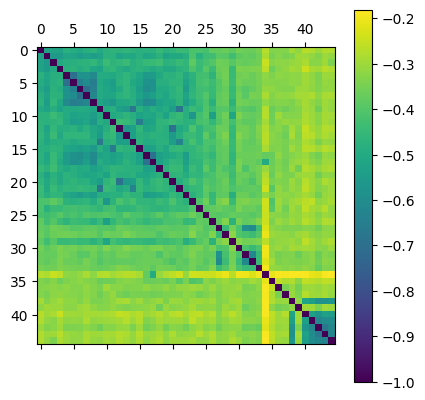

In [62]:
similarity_matrix = []

for i in tqdm(range(len(filtered_sequences))):
    row = []
    for j in range(len(filtered_sequences)):
        similarity = pairwise_sequence_identity(filtered_sequences[i], filtered_sequences[j])
        row.append(similarity)
    similarity_matrix.append(row)

m = np.array(similarity_matrix)
plt.matshow(-m)
plt.colorbar()

In [54]:
redundant_sequences

{1,
 3,
 4,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 17,
 18,
 21,
 22,
 23,
 24,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 39,
 41,
 42,
 44,
 48,
 49,
 50,
 51,
 52,
 55,
 56,
 57,
 58,
 62,
 63,
 64,
 65,
 67,
 70,
 72,
 81,
 85,
 91,
 92,
 96,
 97,
 98}

In [30]:
len(aligned_sequences)

999